In this code , I am trying to solve Combined Allen Cahn and Cahn Hilliard equation using semi-implicit Fourier Spectral Method(Ref-  Zhu J, Chen L-Q, Shen J, Tikare V. Phys. Rev. E 1999;60:3564) .
Here are the details of the variables that I am using:
1. Convention :

 variables starting with (h_) are host variables, (d_) for device variables and variables ending with<_fft> are the corresponding fourier trasforms.


    c(NX*NY) - Concentration
    gc - dF/dc
    eta(N_ORIENT*NY*NX) - Orientation-Parameter
    d_eta - dF/deta
    mu_grad_x / mu_grad_y - gradient(mu)
    j_x / j_y = M.(gradient(mu))
    Mc - Mobility
    rhs_fft - F[grad(M.grad(mu))] where F[.] represents Fourier transform.

2. I have used to different cfft schemes -


    a. forward/backward : to be used for size(NY*NX)/(NY*NX/2+1)
    b. plan_fwd/plan_inv : BATCH TRANSFORM, to be used only for eta and d_eta (size = N_ORIENT*NY*NX/N_ORIENT*NY*(NX/2+1) )
3. Here is the flow of the code for each time step :


    a. For Composition:
      d_c (real) → fft → d_c_fft
      d_gc (real) → fft → d_gc_fft
      → compute mu_grad_x/y in Fourier space → inverse fft → mu_grad_x/y (real)
      → normalize → compute j_x/y → fft → j_x/y_fft
      → compute rhs_fft → update c_fft → inverse fft → d_c (real)->normalize
  
    b.For Order Parameter:
      d_eta(real)->fft->d_eta_fft
      d_d_eta(real) ->fft->d_d_eta_fft
      ->update eta_fft ->inverse ->eta(real) -> normalize


In [37]:
%%writefile code.cu
#include <iostream>
#include <vector>
#include <cmath>
#include <random>
#include <fstream>
#include <string>
#include <cufft.h>

#define CUDA_CHECK(cmd)                                                           \
    do                                                                            \
    {                                                                             \
        cudaError_t e = cmd;                                                      \
        if (e != cudaSuccess)                                                     \
        {                                                                         \
            std::cerr << "CUDA error at " << __FILE__ << ":" << __LINE__ << " - " \
                      << cudaGetErrorString(e) << std::endl;                      \
            exit(EXIT_FAILURE);                                                   \
        }                                                                         \
    } while (0)

// Grid size and related constants
#define NX 256
#define NY 256
#define N (NX * NY)
#define NX_COMPLEX (NX / 2 + 1)

// Simulation parameters
#define DT 0.00001f // Time step
#define N_ORIENT 2
#define M_b 1.0f
#define M_t 1000.0f
#define LAMBDA 1.0f // L is a common macro; renamed to avoid conflicts
#define KAPPA_C 1.0f
#define KAPPA_H 1.0f
#define PI 3.141592653589793f
#define E 1.0f
#define STEPS 20000000
#define A 0.5f
#define c0 0.45f

// Thread/block configuration
#define THREADS 1024
#define SIZE_FFT (NY * NX_COMPLEX)
#define BLOCKS_FFT ((SIZE_FFT + THREADS - 1) / THREADS)
#define BLOCKS_N ((N + THREADS - 1) / THREADS)
#define BLOCKS_ETA ((N * N_ORIENT + THREADS - 1) / THREADS)
#define BLOCKS_ETA_FFT ((N_ORIENT * NY * NX_COMPLEX + THREADS - 1) / THREADS)

cufftHandle forward, backward;
cufftHandle plan_fwd, plan_inv;

void create_fft_plans()
{
    cufftPlan2d(&forward, NY, NX, CUFFT_R2C);
    cufftPlan2d(&backward, NY, NX, CUFFT_C2R);

    int n[2] = {NY, NX}; // 2D dimensions
    int inembed[2] = {NY, NX};
    int onembed[2] = {NY, NX / 2 + 1};

    int batch = N_ORIENT;

    cufftPlanMany(&plan_fwd, 2, n,
                  inembed, 1, NX * NY,
                  onembed, 1, NY * (NX / 2 + 1),
                  CUFFT_R2C, batch);

    cufftPlanMany(&plan_inv, 2, n,
                  onembed, 1, NY * (NX / 2 + 1),
                  inembed, 1, NX * NY,
                  CUFFT_C2R, batch);
}

inline int idx(int x, int y) { return y * NX + x; }
inline int h_idx(int x, int y, int n) { return n * N + y * NX + x; }

void initialize_fields(cufftReal *h_c, cufftReal *d_c, cufftReal *h_eta, cufftReal *d_eta)
{
    std::mt19937 gen(42);
    std::uniform_real_distribution<> dist(-0.01, 0.01);
    int c_x = NX/2;
    int c_y = NY/2;
    int r = 60;
    for (int y = 0; y < NY; ++y)
    {
        for (int x = 0; x < NX; ++x)
        {
            int i = idx(x, y);
            h_c[i] = c0 + dist(gen);
           for (int n = 0; n < N_ORIENT; n++)
            {
                int id = h_idx(x, y, n);
                if ((c_x-x)*(c_x-x) + (c_y-y)*(c_y-y) <= r*r)
                    h_eta[id] = (n == 0) ? 1.0f : 0.0f;
                else
                    h_eta[id] = (n == 1) ? 1.0f : 0.0f;
            }
        }
    }

 /*std::ifstream in("/content/output_files/Initial_Microstructure.bin", std::ios::binary);
    if (!in) {
        std::cerr << "Failed to open file!" << std::endl;
        exit(1);
    }

    in.read(reinterpret_cast<char *>(h_eta), N_ORIENT*N * sizeof(float));
    in.close();*/

    cudaMemcpy(d_c, h_c, N * sizeof(cufftReal), cudaMemcpyHostToDevice);
    cudaMemcpy(d_eta, h_eta, N * N_ORIENT * sizeof(cufftReal), cudaMemcpyHostToDevice);
}

__global__ void compute_k_fields(cufftReal *kx, cufftReal *ky, cufftReal *k2, cufftReal *k4)
{
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    for (int i = index; i < N; i += stride)
    {
        int y = i / NX;
        int x = i % NX;
        int _kx = (x <= NX / 2) ? x : x - NX;
        int _ky = (y <= NY / 2) ? y : y - NY;

        cufftReal kx_ = 2.0f * PI * _kx / NX;
        cufftReal ky_ = 2.0f * PI * _ky / NY;

        kx[i] = kx_;
        ky[i] = ky_;
        k2[i] = kx_ * kx_ + ky_ * ky_;
        k4[i] = k2[i] * k2[i];
    }
}

__device__ cufftReal f0_prime(cufftReal c)
{
    return 2.0 * c * (1 - c) * (1 - 2 * c);
}

__device__ cufftReal m_c(cufftReal c) { return 1.0 + 0.5 * c * c - 0.25 * c * c * (1 - c) * (1 - c); }
__device__ cufftReal m_c_prime(cufftReal c) { return 1.0 * c - 0.25 * (2 * c - 6 * c * c + 4 * c * c * c); }

/*__device__ cufftReal m_c(cufftReal c) { return 1.0 + 0.1 * c * c - 6 * c * c * (1 - c) * (1 - c); }
__device__ cufftReal m_c_prime(cufftReal c) { return 0.2 * c - 6 * (2 * c - 6 * c * c + 4 * c * c * c); }*/

/*__device__ cufftReal m_c(cufftReal c) { return 1.0 + 0.1 * c * c ; }
__device__ cufftReal m_c_prime(cufftReal c) { return 0.2 * c; }*/

__device__ int flat_idx(int x, int y)
{
    return y * NX + x;
}

__device__ int eta_idx(int x, int y, int n)
{
    return ((n * NX * NY) + (y * NX) + x);
}

__global__ void compute_derivatives(const cufftReal *__restrict__ d_eta, const cufftReal *__restrict__ d_c, cufftReal *d_gc, cufftReal *d_d_eta, cufftReal *d_Mc)
{
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    for (int i = index; i < N; i += stride)
    {
        cufftReal c_val = d_c[i];
        int y = i / NX;
        int x = i % NX;
        cufftReal hi2_sum = 0.0f, hi4_sum = 0.0f, hij2_sum = 0.0f;
        cufftReal h_vals[N_ORIENT];

        // Load eta values
        for (int n = 0; n < N_ORIENT; ++n)
        {
            h_vals[n] = d_eta[eta_idx(x, y, n)];
        }

        for (int n = 0; n < N_ORIENT; ++n)
        {
            cufftReal h = h_vals[n];
            hi2_sum += h * h;
            hi4_sum += h * h * h * h;

            for (int m = 0; m < N_ORIENT; ++m)
            {
                if (m > n)
                    hij2_sum += h * h * h_vals[m] * h_vals[m];
            }
        }

        cufftReal hsum = -0.25f * (hi2_sum - hi4_sum - 2.0f * E * hij2_sum);
        d_gc[i] = f0_prime(c_val) + m_c_prime(c_val) * hsum;

        for (int n = 0; n < N_ORIENT; ++n)
        {
            cufftReal h = h_vals[n];
            cufftReal dh = -h + (h * h * h);

            cufftReal temp = 0.0f;
            for (int m = 0; m < N_ORIENT; ++m)
            {
                if (m != n)
                    temp += h * h_vals[m] * h_vals[m];
            }

            dh += 2.0f * E * temp;
            dh *= m_c(c_val);
            d_d_eta[eta_idx(x, y, n)] = dh;
        }

        // Update mobility Mc[i] using h_vals
        cufftReal sum = 0.0f;
        for (int n = 0; n < N_ORIENT; ++n)
        {
            for (int m = n + 1; m < N_ORIENT; ++m)
            {
                cufftReal hni = h_vals[n];
                cufftReal hmi = h_vals[m];
                sum += hni * hni * hmi * hmi;
            }
        }

        d_Mc[i] = M_b + M_t * sqrtf(fmaxf(0.0f, sum));
    }
}

__global__ void compute_mu_grad_fft(cufftComplex *mu_grad_x_fft, cufftComplex *mu_grad_y_fft, const cufftComplex *g_fft, const cufftComplex *c_fft, const cufftReal *kx, const cufftReal *ky, const cufftReal *k2)
{
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    for (int i = index; i < NY * NX_COMPLEX; i += stride)
    {
        int j = (i % NX_COMPLEX) + (i / NX_COMPLEX) * NX;
        cufftReal val_re = g_fft[i].x + KAPPA_C * k2[j] * c_fft[i].x;
        cufftReal val_im = g_fft[i].y + KAPPA_C * k2[j] * c_fft[i].y;
        mu_grad_x_fft[i].x = kx[j] * val_re;
        mu_grad_x_fft[i].y = kx[j] * val_im;
        mu_grad_y_fft[i].x = ky[j] * val_re;
        mu_grad_y_fft[i].y = ky[j] * val_im;
    }
}

__global__ void normalize_and_compute_j(cufftReal *mu_grad_x, cufftReal *mu_grad_y, const cufftReal *Mc, cufftReal *j_x, cufftReal *j_y)
{
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    for (int i = index; i < N; i += stride)
    {
        mu_grad_x[i] /= N;
        mu_grad_y[i] /= N;
        j_x[i] = Mc[i] * mu_grad_x[i];
        j_y[i] = Mc[i] * mu_grad_y[i];
    }
}

__global__ void compute_rhs_fft(cufftComplex *rhs_fft, const cufftComplex *j_x_fft, const cufftComplex *j_y_fft, const cufftReal *kx, const cufftReal *ky)
{
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    for (int i = index; i < NY * NX_COMPLEX; i += stride)
    {
        int y = i / NX_COMPLEX;
        int x = i % NX_COMPLEX;
        int j = y * NX + x; // Correct full grid index

        cufftReal jx_re = j_x_fft[i].x;
        cufftReal jx_im = j_x_fft[i].y;
        cufftReal jy_re = j_y_fft[i].x;
        cufftReal jy_im = j_y_fft[i].y;

        rhs_fft[i].x = kx[j] * jx_re + ky[j] * jy_re;
        rhs_fft[i].y = kx[j] * jx_im + ky[j] * jy_im;
    }
}

__global__ void update_c_fft(cufftComplex *c_fft, const cufftComplex *rhs_fft, const cufftReal *k2, const cufftReal *k4)
{
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    for (int i = index; i < NY * NX_COMPLEX; i += stride)
    {
        int j = (i % NX_COMPLEX) + (i / NX_COMPLEX) * NX;
        cufftReal denom = 1.0f + A * DT * KAPPA_C * k4[j];
        if (denom < 1e-12f)
            denom = 1e-12f;
        c_fft[i].x = c_fft[i].x - ((DT * rhs_fft[i].x) / denom);
        c_fft[i].y = c_fft[i].y - ((DT * rhs_fft[i].y) / denom);
    }
}

__global__ void update_eta_fft(cufftComplex *eta_fft, const cufftComplex *d_eta_fft, const cufftReal *k2)
{
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    for (int i = index; i < N_ORIENT * NY * NX_COMPLEX; i += stride)
    {
        int local_idx = i % (NY * NX_COMPLEX);

        int ky = local_idx / NX_COMPLEX;  // row index (0 to NY-1)
        int kx = local_idx % NX_COMPLEX;  // column index (0 to NX_COMPLEX-1)

        int j = ky * NX + kx; // This will work only if k2 is padded to full NX

        cufftReal denom = 1.0f + 2.0f * DT * LAMBDA * KAPPA_H * k2[j];
        if (denom < 1e-12f)
            denom = 1e-12f;
        eta_fft[i].x = (eta_fft[i].x - DT * LAMBDA * d_eta_fft[i].x) / denom;
        eta_fft[i].y = (eta_fft[i].y - DT * LAMBDA * d_eta_fft[i].y) / denom;
    }
}

__global__ void normalize_c(cufftReal *c)
{
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    for (int i = index; i < N; i += stride)
        c[i] = c[i] / N;
}

__global__ void normalize_eta(cufftReal *eta)
{
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    for (int i = index; i < N * N_ORIENT; i += stride)
        eta[i] = eta[i] / N;
}

void time_step(
    cufftReal *d_c, cufftReal *d_gc, cufftReal *d_mu_grad_x, cufftReal *d_mu_grad_y,
    cufftReal *d_j_x, cufftReal *d_j_y, cufftComplex *d_c_fft, cufftComplex *d_gc_fft,
    cufftComplex *d_mu_grad_x_fft, cufftComplex *d_mu_grad_y_fft, cufftComplex *d_j_x_fft, cufftComplex *d_j_y_fft,
    cufftComplex *d_rhs_fft, cufftComplex *d_eta_fft, cufftComplex *d_d_eta_fft,
    cufftReal *d_kx, cufftReal *d_ky, cufftReal *d_k2, cufftReal *d_k4, cufftReal *d_Mc,
    cufftReal *d_eta, cufftReal *d_d_eta, cufftHandle forward, cufftHandle backward, cufftHandle plan_fwd, cufftHandle plan_inv)
{
    compute_derivatives<<<BLOCKS_N, THREADS>>>(d_eta, d_c, d_gc, d_d_eta, d_Mc);
    cudaDeviceSynchronize();
    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
          printf("Kernel launch failed: %s\n", cudaGetErrorString(err));
      }

    // Execute forward FFT on c and gc

    cufftExecR2C(forward, d_c, d_c_fft);
    cufftExecR2C(forward, d_gc, d_gc_fft);

    // Compute mu_grad_x_fft and mu_grad_y_fft

    compute_mu_grad_fft<<<BLOCKS_FFT, THREADS>>>(d_mu_grad_x_fft, d_mu_grad_y_fft, d_gc_fft, d_c_fft, d_kx, d_ky, d_k2);
    cudaDeviceSynchronize();
    err = cudaGetLastError();
    if (err != cudaSuccess) {
          printf("Kernel launch failed: %s\n", cudaGetErrorString(err));
      }

    // Inverse FFT mu_grad_x_fft and mu_grad_y_fft to real space

    cufftExecC2R(backward, d_mu_grad_x_fft, d_mu_grad_x);
    cufftExecC2R(backward, d_mu_grad_y_fft, d_mu_grad_y);

    // Normalize and compute fluxes j_x, j_y

    normalize_and_compute_j<<<BLOCKS_N, THREADS>>>(d_mu_grad_x, d_mu_grad_y, d_Mc, d_j_x, d_j_y);
    cudaDeviceSynchronize();
    err = cudaGetLastError();
    if (err != cudaSuccess) {
          printf("Kernel launch failed: %s\n", cudaGetErrorString(err));
      }

    // Forward FFT j_x and j_y

    cufftExecR2C(forward, d_j_x, d_j_x_fft);
    cufftExecR2C(forward, d_j_y, d_j_y_fft);

    // Compute rhs_fft

    compute_rhs_fft<<<BLOCKS_FFT, THREADS>>>(d_rhs_fft, d_j_x_fft, d_j_y_fft, d_kx, d_ky);
    cudaDeviceSynchronize();
    err = cudaGetLastError();
    if (err != cudaSuccess) {
          printf("Kernel launch failed: %s\n", cudaGetErrorString(err));
      }

    // Update c_fft

    update_c_fft<<<BLOCKS_FFT, THREADS>>>(d_c_fft, d_rhs_fft, d_k2, d_k4);
    cudaDeviceSynchronize();
    err = cudaGetLastError();
    if (err != cudaSuccess) {
          printf("Kernel launch failed: %s\n", cudaGetErrorString(err));
      }

    // Inverse FFT c_fft to real c

    cufftExecC2R(backward, d_c_fft, d_c);
    normalize_c<<<BLOCKS_N, THREADS>>>(d_c);
    cudaDeviceSynchronize();
    err = cudaGetLastError();
    if (err != cudaSuccess) {
          printf("Kernel launch failed: %s\n", cudaGetErrorString(err));
      }

    // compute h_fft

    cufftExecR2C(plan_fwd, d_eta, d_eta_fft);
    cufftExecR2C(plan_fwd, d_d_eta, d_d_eta_fft);

    update_eta_fft<<<BLOCKS_ETA_FFT, THREADS>>>(d_eta_fft, d_d_eta_fft, d_k2);
    cudaDeviceSynchronize();
    err = cudaGetLastError();
    if (err != cudaSuccess) {
          printf("Kernel launch failed: %s\n", cudaGetErrorString(err));
      }

    cufftExecC2R(plan_inv, d_eta_fft, d_eta);
    normalize_eta<<<BLOCKS_ETA, THREADS>>>(d_eta);
    cudaDeviceSynchronize();
    err = cudaGetLastError();
    if (err != cudaSuccess) {
          printf("Kernel launch failed: %s\n", cudaGetErrorString(err));
      }
}

void write_field_to_binary(const cufftReal *field, size_t size, const std::string &filename)
{
    std::ofstream out(filename, std::ios::binary);
    if (!out)
        return;
    out.write(reinterpret_cast<const char *>(field), size * sizeof(cufftReal));
    out.close();
}

int main()
{
    cufftReal *h_c, *h_eta;
    cufftReal *d_kx, *d_ky, *d_k2, *d_k4;
    cufftReal *d_c, *d_gc, *d_mu_grad_x, *d_mu_grad_y, *d_j_x, *d_j_y, *d_eta, *d_d_eta, *d_Mc;
    cufftComplex *d_c_fft, *d_gc_fft, *d_mu_grad_x_fft, *d_mu_grad_y_fft, *d_j_x_fft, *d_j_y_fft, *d_eta_fft, *d_d_eta_fft, *d_rhs_fft;


    cudaHostAlloc((void **)&h_c, N * sizeof(cufftReal), cudaHostAllocDefault);
    cudaHostAlloc((void **)&h_eta, N * N_ORIENT * sizeof(cufftReal), cudaHostAllocDefault);

    CUDA_CHECK(cudaMalloc((void **)&d_Mc, N * sizeof(cufftReal)));
    CUDA_CHECK(cudaMalloc((void **)&d_kx, N * sizeof(cufftReal)));
    CUDA_CHECK(cudaMalloc((void **)&d_ky, N * sizeof(cufftReal)));
    CUDA_CHECK(cudaMalloc((void **)&d_k2, N * sizeof(cufftReal)));
    CUDA_CHECK(cudaMalloc((void **)&d_k4, N * sizeof(cufftReal)));
    CUDA_CHECK(cudaMalloc((void **)&d_c, N * sizeof(cufftReal)));
    CUDA_CHECK(cudaMalloc((void **)&d_gc, N * sizeof(cufftReal)));
    CUDA_CHECK(cudaMalloc((void **)&d_mu_grad_x, N * sizeof(cufftReal)));
    CUDA_CHECK(cudaMalloc((void **)&d_mu_grad_y, N * sizeof(cufftReal)));
    CUDA_CHECK(cudaMalloc((void **)&d_j_x, N * sizeof(cufftReal)));
    CUDA_CHECK(cudaMalloc((void **)&d_j_y, N * sizeof(cufftReal)));

    cudaError_t err = cudaMalloc((void **)&d_eta, N * N_ORIENT * sizeof(cufftReal));
    if (err != cudaSuccess)
    {
        std::cerr << "cudaMalloc failed for d_eta: " << cudaGetErrorString(err) << std::endl;
        exit(1);
    }

    err = cudaMalloc((void **)&d_d_eta, N * N_ORIENT * sizeof(cufftReal));
    if (err != cudaSuccess)
    {
        std::cerr << "cudaMalloc failed for d_d_eta: " << cudaGetErrorString(err) << std::endl;
        exit(1);
    }
    CUDA_CHECK(cudaMalloc((void **)&d_c_fft, NY * NX_COMPLEX * sizeof(cufftComplex)));
    CUDA_CHECK(cudaMalloc((void **)&d_gc_fft, NY * NX_COMPLEX * sizeof(cufftComplex)));
    CUDA_CHECK(cudaMalloc((void **)&d_mu_grad_x_fft, NY * NX_COMPLEX * sizeof(cufftComplex)));
    CUDA_CHECK(cudaMalloc((void **)&d_mu_grad_y_fft, NY * NX_COMPLEX * sizeof(cufftComplex)));
    CUDA_CHECK(cudaMalloc((void **)&d_j_x_fft, NY * NX_COMPLEX * sizeof(cufftComplex)));
    CUDA_CHECK(cudaMalloc((void **)&d_j_y_fft, NY * NX_COMPLEX * sizeof(cufftComplex)));
    CUDA_CHECK(cudaMalloc((void **)&d_rhs_fft, NY * NX_COMPLEX * sizeof(cufftComplex)));
    CUDA_CHECK(cudaMalloc((void **)&d_eta_fft, N_ORIENT * NX_COMPLEX * NY * sizeof(cufftComplex)));
    CUDA_CHECK(cudaMalloc((void **)&d_d_eta_fft, N_ORIENT * NX_COMPLEX * NY * sizeof(cufftComplex)));

    initialize_fields(h_c, d_c , h_eta, d_eta);

    create_fft_plans();

    compute_k_fields<<<BLOCKS_N, THREADS>>>(d_kx, d_ky, d_k2, d_k4);
    cudaDeviceSynchronize();
    err = cudaGetLastError();
    if (err != cudaSuccess) {
          printf("Kernel launch failed: %s\n", cudaGetErrorString(err));
      }

    cufftReal *h_debug = new cufftReal[N];

    for (size_t step = 0; step <= STEPS; ++step)
    {
        if (step % (STEPS / 10) == 0)
        {
            cudaMemcpy(h_c, d_c, N * sizeof(cufftReal), cudaMemcpyDeviceToHost);
            cudaMemcpy(h_eta, d_eta, N * N_ORIENT * sizeof(cufftReal), cudaMemcpyDeviceToHost);
            std::cout << "Time: " << step*DT << std::endl;
            //write_field_to_binary(h_c, N, "c_new_" + std::to_string(step) + ".bin");
            //write_field_to_binary(h_eta, N * N_ORIENT, "h_new_" + std::to_string(step) + ".bin");
            write_field_to_binary(h_c, N, "c_new_" + std::to_string(int(step * DT)) + ".bin");
            write_field_to_binary(h_eta, N * N_ORIENT, "h_new_" + std::to_string(int(step * DT)) + ".bin");
        }
        time_step(d_c, d_gc, d_mu_grad_x, d_mu_grad_y, d_j_x, d_j_y,
                  d_c_fft, d_gc_fft, d_mu_grad_x_fft, d_mu_grad_y_fft, d_j_x_fft, d_j_y_fft,
                  d_rhs_fft, d_eta_fft, d_d_eta_fft,
                  d_kx, d_ky, d_k2, d_k4, d_Mc, d_eta, d_d_eta,
                  forward, backward, plan_fwd, plan_inv);
    }

    // Free host pinned memory
    cudaFreeHost(h_c);
    cudaFreeHost(h_eta);

    // Free device memory
    cudaFree(d_Mc);
    cudaFree(d_kx);
    cudaFree(d_ky);
    cudaFree(d_k2);
    cudaFree(d_k4);

    cudaFree(d_c);
    cudaFree(d_gc);
    cudaFree(d_mu_grad_x);
    cudaFree(d_mu_grad_y);
    cudaFree(d_j_x);
    cudaFree(d_j_y);
    cudaFree(d_eta);
    cudaFree(d_d_eta);

    cudaFree(d_c_fft);
    cudaFree(d_gc_fft);
    cudaFree(d_mu_grad_x_fft);
    cudaFree(d_mu_grad_y_fft);
    cudaFree(d_j_x_fft);
    cudaFree(d_j_y_fft);
    cudaFree(d_eta_fft);
    cudaFree(d_d_eta_fft);

    // Destroy cuFFT plans
    cufftDestroy(forward);
    cufftDestroy(backward);
    cufftDestroy(plan_fwd);
    cufftDestroy(plan_inv);

    return 0;
}

Overwriting code.cu


In [38]:
!nvcc -arch=sm_75 code.cu -o code -lcufft



In [39]:
!./code



Time: 0
Time: 20
Time: 40
Time: 60
Time: 80
Time: 100
Time: 120
Time: 140
Time: 160
Time: 180
Time: 200


/tmp/ipython-input-40-3092693442.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.96])  # Optional


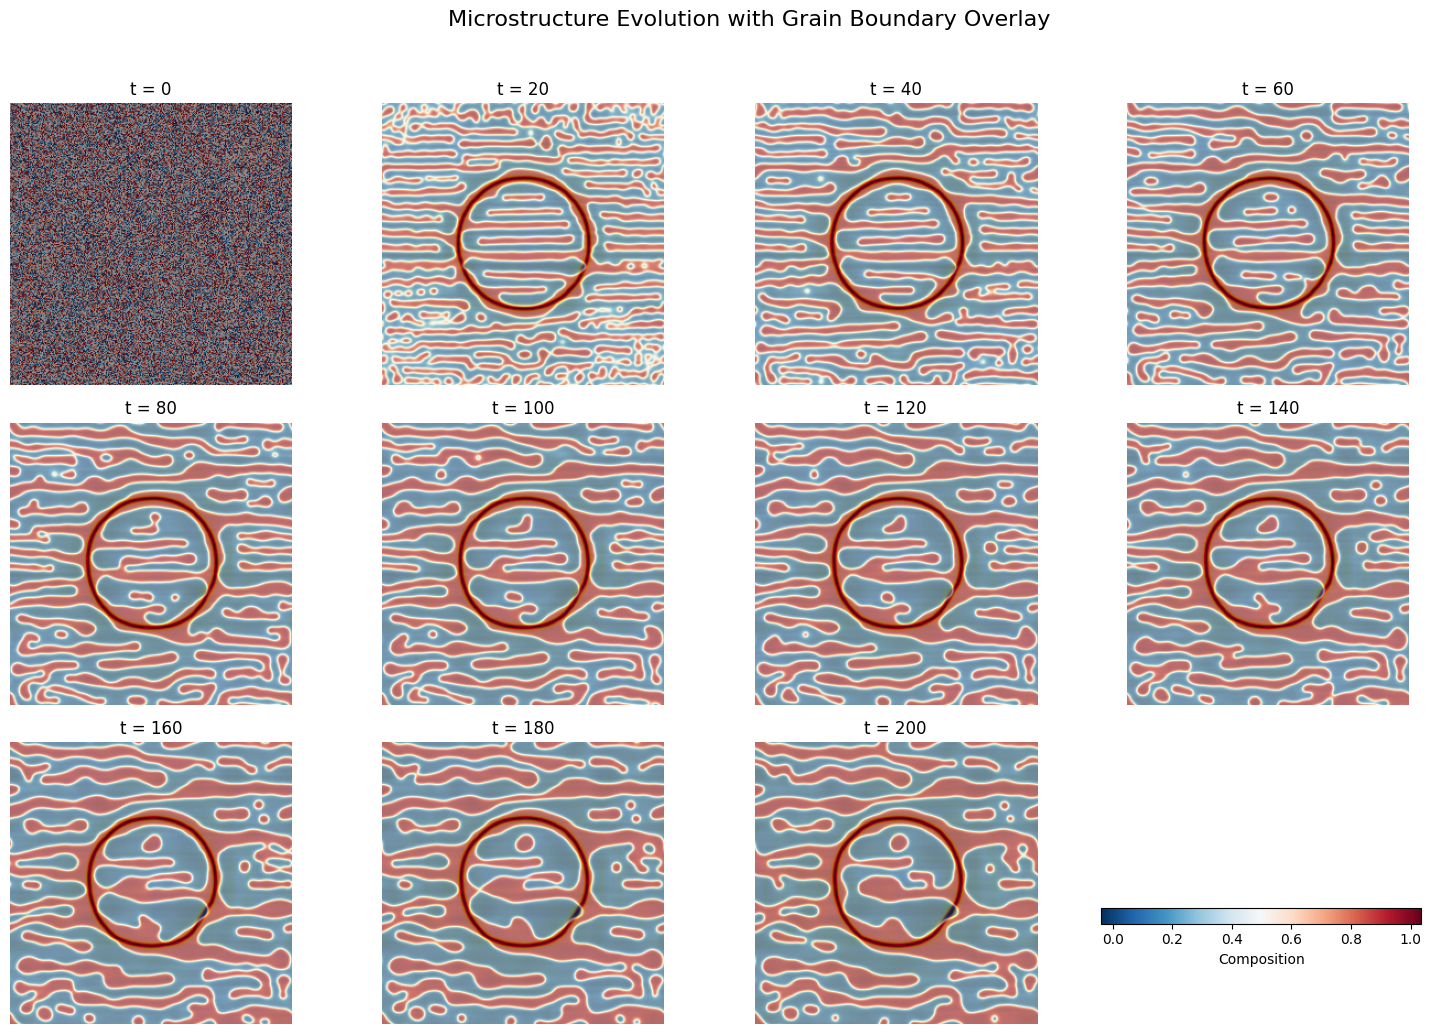

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import math
ny = 256
nx = 256
n_orient = 2
n_files = 11
time_step = 20

data = np.empty((n_files, ny * nx), dtype=np.float32)  # concentration
data_h = np.empty((n_files, n_orient * ny * nx), dtype=np.float32)  # eta fields
values = np.empty((n_files, ny * nx), dtype=np.float32)  # product of eta_i

# Load data from files
for i in range(n_files):
    filename_c = f"c_new_{i * time_step}.bin"
    data[i] = np.fromfile(filename_c, dtype=np.float32)
    filename_h = f"h_new_{i * time_step}.bin"
    data_h[i] = np.fromfile(filename_h, dtype=np.float32)

# Compute product of eta_i at each grid point
for i in range(n_files):
    for j in range(ny * nx):
        sum = 0
        for k in range(n_orient):
            sum += data_h[i, k * ny * nx + j]*data_h[i, k * ny * nx + j]
        values[i, j] = sum

n_cols = math.ceil(math.sqrt(n_files))  # Round up square root
n_rows = math.ceil(n_files / n_cols)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows))
axes = axes.flatten()

for i in range(n_files):
    comp = data[i].reshape((ny, nx))

    orient = values[i].reshape((ny, nx))

    ax = axes[i]
    img = ax.imshow(comp, cmap='RdBu_r', origin='lower')
    im = ax.imshow(orient, cmap='hot', origin='lower', alpha=0.4)  # adjust alpha to taste

    ax.set_title(f"t = {i * time_step}")
    ax.axis('off')

# Delete unused axes if n_files < total subplots
for idx in range(n_files, len(axes)):
    fig.delaxes(axes[idx])

# Shared colorbar
cbar_ax = fig.add_axes([0.72,0.11,0.2,0.015 ])  # Adjust as needed
cbar = fig.colorbar(img , cax=cbar_ax,orientation='horizontal')
cbar.set_label("Composition")

plt.suptitle("Microstructure Evolution with Grain Boundary Overlay", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.95, 0.96])  # Optional
plt.show()

In [11]:
import numpy as np
data = np.fromfile('c_new_50.bin', dtype=np.float32)
print("Mean:", data.mean(), "Max:", data.max(), "Min:", data.min())

Mean: 0.4500106 Max: 1.0273554 Min: -0.030950982


In [41]:
import shutil

# Create a folder to collect your output files
!mkdir output_files

# Move all .bin files into that folder
!mv *.bin output_files/

# Zip the folder
shutil.make_archive("circular_Mt1000_L1_t=200", 'zip', "output_files")

mkdir: cannot create directory ‘output_files’: File exists


'/content/circular_Mt1000_L1_t=200.zip'